In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim import Adam

from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pth"

## Execution options

Here's a few options you should set:

 - `no_train` specifies whether you want to skip the training loop and just use a pre-trained model. If you haven't trained a model already using this notebook, keep this as `False`. If you want to use a pre-trained model, load it in the colab filesystem.

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.


In [2]:
no_train = False
batch_size = 128
n_epochs = 50
lr = 0.001
noise = 1e-5
grad_clamp = 1.5

# Utility functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [3]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [4]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

## Loading data
We will use the MNIST dataset and try to generate some new samples out of (nowhere, but starting from some) random gaussian noise. **NOTE**: It is important to normalize images in range `[-1,1]` and not `[0,1]` as one might usually do. This is because the DDPM network predicts normally distributed noises throughout the denoising process.

In [5]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

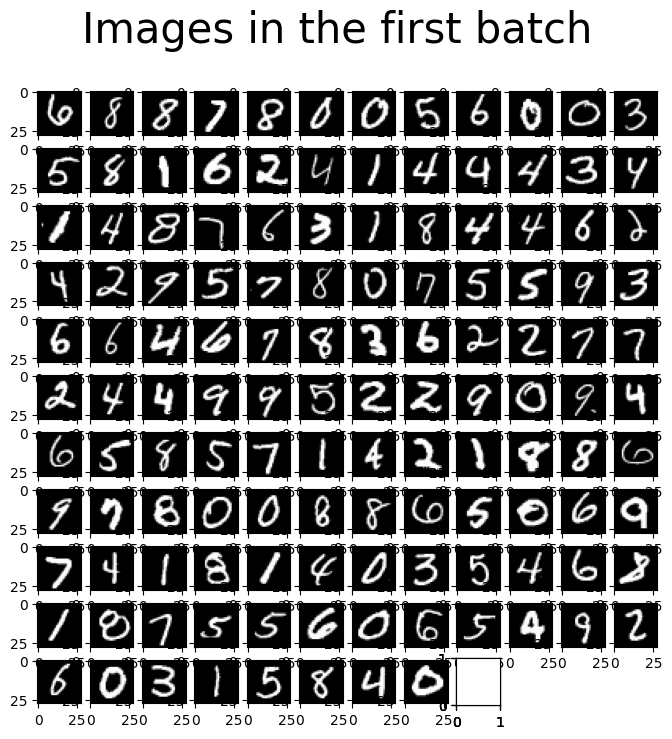

In [6]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [7]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 3060 Laptop GPU


# Defining the DDPM module

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [8]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Visualizing forward and backward

Now that we have defined the high-level functioning of a DDPM model, we can already define some related utility functions.

In particular, we will be showing the forward process (which is independent of the denoising network) with the `show_forward` method.

We run the backward pass and generate new images with the `generate_new_images` method, but this time we will put more effort into the function and also make it such that a GIF image is created. Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In this implementation, they are both a few line-comments away. However, the two terms are rougly always the same and little difference is noticeable. By default, I choose the first option out of simplicity.

In [9]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [10]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            rgb_frame = np.repeat(frame, 3, axis=2)
            writer.append_data(rgb_frame)

            # Showing the last frame for a longer time
            if idx == len(frames) - 1:
                last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                for _ in range(frames_per_gif // 3):
                    writer.append_data(last_rgb_frame)
    return x

# UNet architecture

Okay great! All that concerns DDPM is down on the table already. So now we simply define an architecture that will be responsible of denoising the we should be good to go... Not so fast! While in principle that's true, we have to be careful to conditioning our model with the temporal information.

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.

**NOTE:** This UNet architecture is purely arbitrary and was desined to work with 28x28 spatial resolution images.

In [11]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [12]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [13]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Instantiating the model

We are finally done! Now we simply need to instantiate a model, optionally play a bit with it (show forward and backward processes) and write the usual code that defines a training loop for our model. When the model will be done training, we will test it's generative capabilities.

In [14]:
# # Defining model
n_steps, min_beta, max_beta = 1500, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [15]:
sum([p.numel() for p in ddpm.parameters()])

656852

In [16]:
# ddpm.network

In [17]:
# for parameter in ddpm.parameters():
#     parameter.requires_grad = True
#     parameter.register_hook(
#         lambda grad: grad + (1/batch_size)*sigma * torch.randn(parameter.shape).cuda()
#     )

In [18]:
# ddpm.network.time_embed.requires_grad = False

# Optional visualizations

In [19]:
# Optionally, load a pre-trained model that will be further trained
# ddpm.load_state_dict(torch.load(store_path, map_location=device))

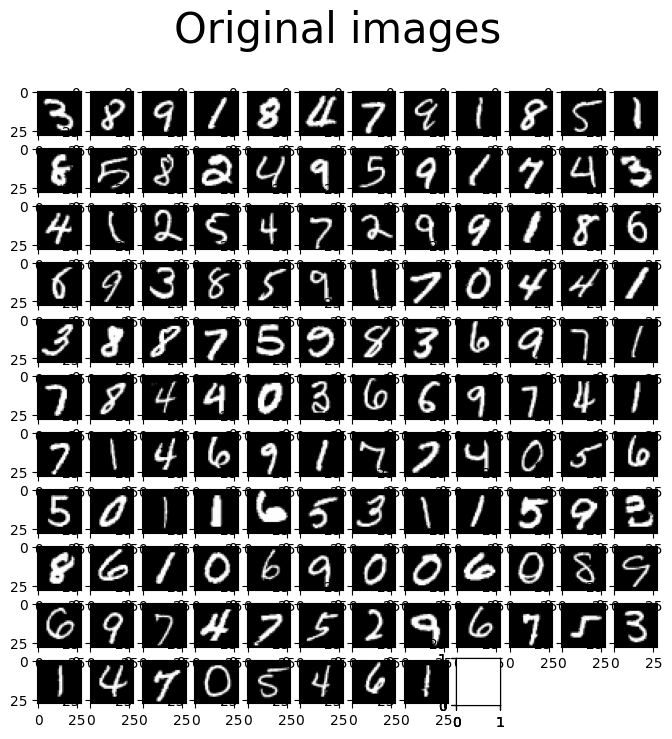

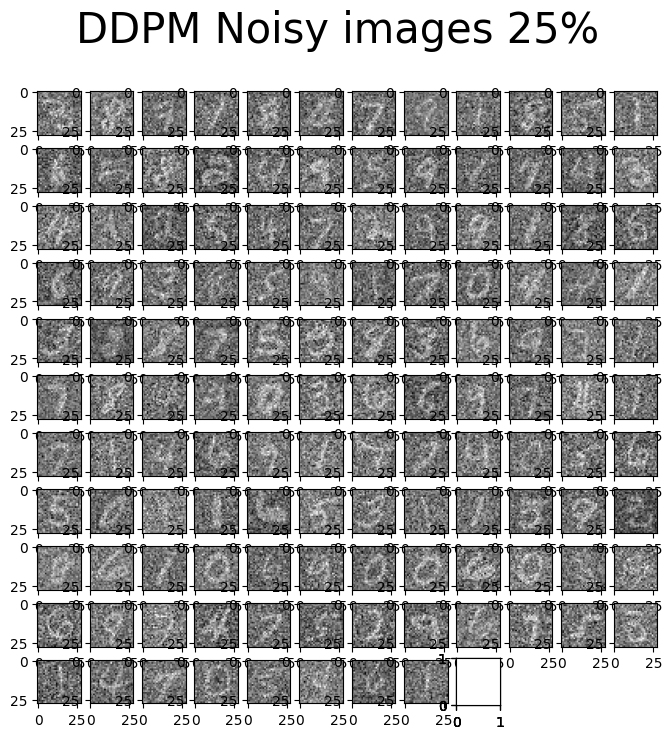

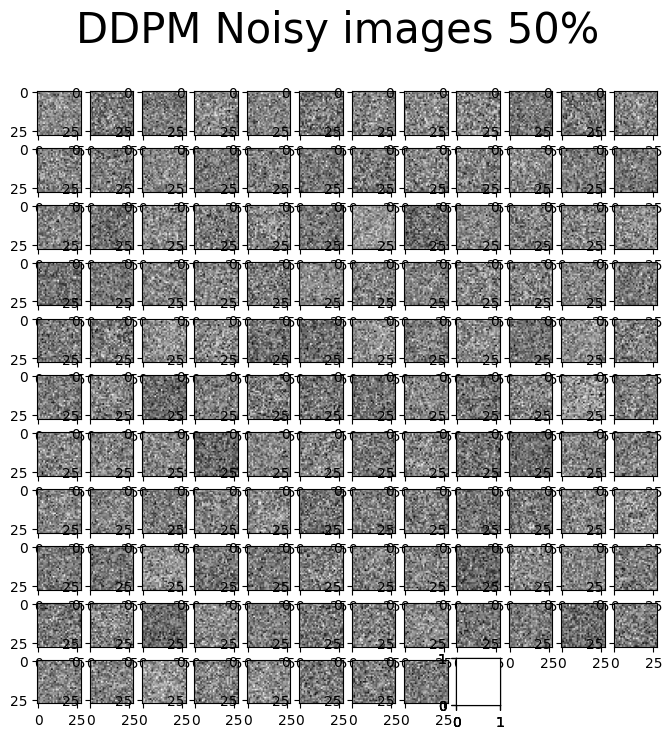

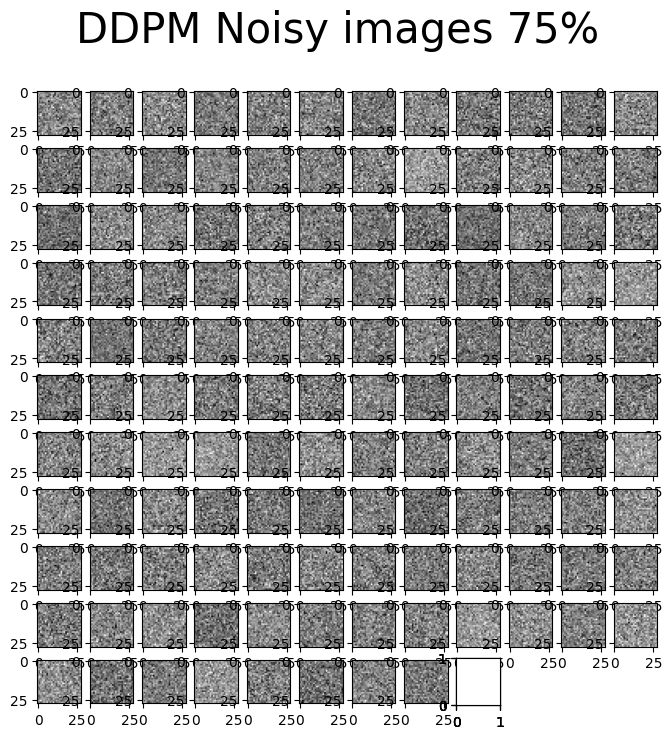

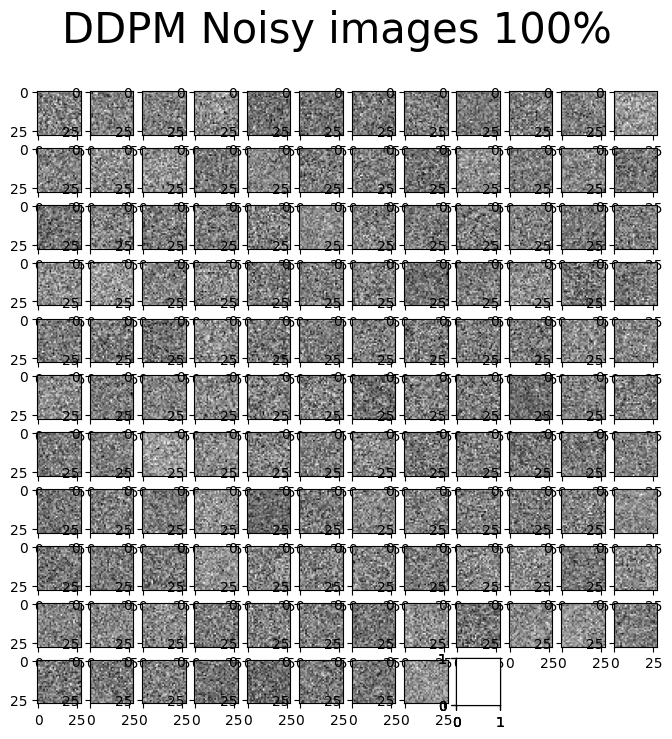

In [20]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

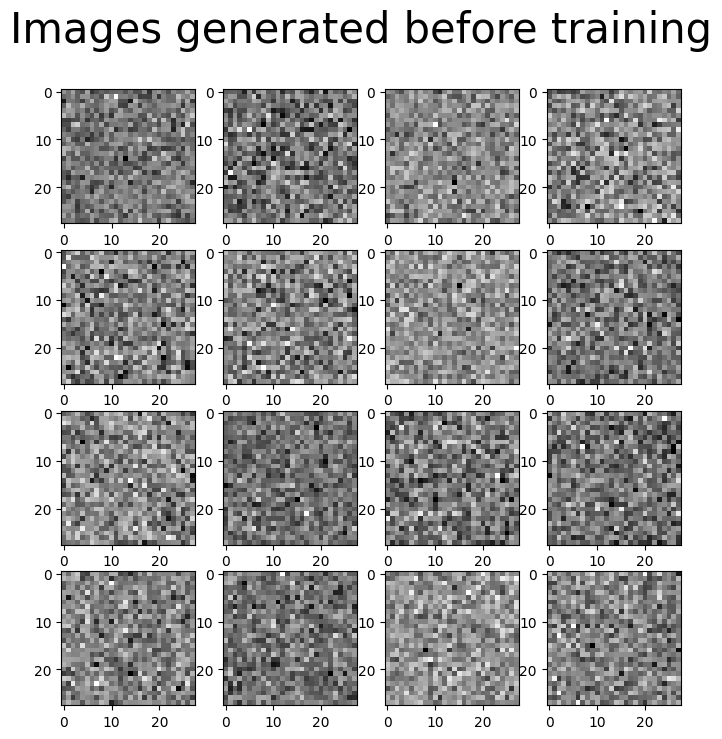

In [21]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

# Training loop

The training loop is fairly simple. With each batch of our dataset, we run the forward process on the batch. We use a different timesteps $t$ for each of the `N` images in our `(N, C, H, W)` batch tensor to guarantee more training stability. The added noise is a `(N, C, H, W)` tensor $\epsilon$.

Once we obtained the noisy images, we try to predict $\epsilon$ out of them with our network. We optimize with a simple Mean-Squared Error (MSE) loss.

In [22]:
import wandb
import warnings
# 
# warnings.simplefilter("ignore")
# wandb.login(key="c8b7ef31a46dca526003891b3b6dda9f2a6391cf")
# 
# run = wandb.init(
#     # set the wandb project where this run will be logged
#     project="2412 DP Diffusion Model",
#     entity="2412",
#     config={
#         "learning_rate": lr,
#         "architecture": "DDM",
#         "dataset": "MNIST",
#         "optimizer": "Adam",
#         "loss function": "MSE",
#         "epochs": n_epochs,
#         "Epsilon": epsilon
#     },
# )

In [23]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt", epsilon=5):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            
            # weight clipping for privacy guarantee
            for param in ddpm.network.parameters():
                param.data.clamp_(-grad_clamp, grad_clamp)
                epoch_loss += loss.item() * len(x0) / len(loader.dataset)
                # run.log({"Epoch Loss":epoch_loss})
            
            loss.backward()
            optim.step()
        
        # Display images generated at this epoch
        if display and epoch%10==0:
            generated = generate_new_images(ddpm, device=device, n_samples=100, gif_name=f"output/dpdiffusion/epsilon_{epsilon}/mnist_{epoch}.gif")
            # run.log({"Generated Images": wandb.Video(f"output/dpdiffusion/epsilon_{epsilon}/mnist_{epoch}.gif", caption=f"Generated at {epoch}")})

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), f"{store_path}_{epsilon}.pth")
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [24]:
# # Training
# store_path = "ddpm_mnist.pth"
# optim = Adam(ddpm.parameters(), lr, betas=(0,0.9))
# 
# if not no_train:
#     training_loop(ddpm, loader, n_epochs, optim=optim, device=device, store_path=store_path)

In [25]:
# artifact = wandb.Artifact('model', type='model')
# 
# torch.save(ddpm.state_dict(), "ddpm_mnist.pth")
# 
# artifact.add_file("ddpm_mnist.pth")
# run.log_artifact(artifact)

In [26]:
# run.finish()

# Testing the trained model

Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [27]:
# # Loading the trained model
# best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
# best_model.load_state_dict(torch.load("models/dpdiffusion/model.pth", map_location=device))
# best_model.eval()
# print("Model loaded")

In [28]:
# print("Generating new images")
# generated = generate_new_images(
#         best_model,
#         n_samples=100,
#         device=device,
#         gif_name= "dpmnist.gif"
#     )
# show_images(generated, "Final result")

In [29]:
def experiment():
    # import wandb
    # import warnings
    #     
    # warnings.simplefilter("ignore")
    # wandb.login(key="c8b7ef31a46dca526003891b3b6dda9f2a6391cf")
    
    
    trials = [(5,1.35), (10,1.1), (40,0.79)]
    
    for trial in trials:
        epsilon = trial[0]
        sigma = trial[1]
        
        print(f"Running the Trial for epsilon: {epsilon}")
        # Defining model
        n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
        ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
        
        for parameter in ddpm.parameters():
            parameter.requires_grad = True
            parameter.register_hook(
                lambda grad: grad + (1/batch_size)*sigma * torch.randn(parameter.shape).cuda()
            )
        ddpm.network.time_embed.requires_grad = False
        
        store_path = f"models/dpdiffusion/ddpm_mnist_{epsilon}"
        
        
        # run = wandb.init(
        #     # set the wandb project where this run will be logged
        #     project="2412 DP Diffusion Model",
        #     entity="2412",
        #     config={
        #         "learning_rate": lr,
        #         "architecture": "DDM",
        #         "dataset": "MNIST",
        #         "optimizer": "Adam",
        #         "loss function": "MSE",
        #         "epochs": n_epochs,
        #         "Epsilon": epsilon
        #     },
        # )
        
        optim = Adam(ddpm.parameters(), lr, betas=(0,0.9))
        training_loop(ddpm, loader, n_epochs, optim=optim, device=device, store_path=store_path, display=True, epsilon=epsilon)
        # 
        # artifact = wandb.Artifact('model', type='model')
        # 
        # torch.save(ddpm.state_dict(), f"ddpm_mnist_{epsilon}.pth")
        # 
        # artifact.add_file(f"ddpm_mnist_{epsilon}.pth")
        # run.log_artifact(artifact)
        
        # run.finish()

In [30]:
experiment()

Running the Trial for epsilon: 5


Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 87.949 --> Best model ever (stored)


Epoch 2/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 28.668 --> Best model ever (stored)


Epoch 3/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 20.545 --> Best model ever (stored)


Epoch 4/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 17.216 --> Best model ever (stored)


Epoch 5/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 16.350 --> Best model ever (stored)


Epoch 6/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 19.704


Epoch 7/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 16.042 --> Best model ever (stored)


Epoch 8/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 15.786 --> Best model ever (stored)


Epoch 9/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 19.314


Epoch 10/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 26.030


Epoch 11/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 19.663


Epoch 12/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 17.681


Epoch 13/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 15.203 --> Best model ever (stored)


Epoch 14/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 14.490 --> Best model ever (stored)


Epoch 15/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 13.836 --> Best model ever (stored)


Epoch 16/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 12.814 --> Best model ever (stored)


Epoch 17/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 12.271 --> Best model ever (stored)


Epoch 18/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 12.225 --> Best model ever (stored)


Epoch 19/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 11.945 --> Best model ever (stored)


Epoch 20/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 12.468


Epoch 21/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 21: 12.468


Epoch 22/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 22: 11.967


Epoch 23/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 23: 11.232 --> Best model ever (stored)


Epoch 24/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 24: 11.345


Epoch 25/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 25: 11.587


Epoch 26/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 26: 11.098 --> Best model ever (stored)


Epoch 27/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 27: 10.475 --> Best model ever (stored)


Epoch 28/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 28: 11.190


Epoch 29/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 29: 11.958


Epoch 30/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 30: 11.068


Epoch 31/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 31: 10.712


Epoch 32/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 32: 10.397 --> Best model ever (stored)


Epoch 33/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 33: 10.398


Epoch 34/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 34: 12.718


Epoch 35/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 35: 12.721


Epoch 36/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 36: 13.493


Epoch 37/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 37: 13.073


Epoch 38/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 38: 12.349


Epoch 39/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 39: 11.753


Epoch 40/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 40: 11.052


Epoch 41/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 41: 10.708


Epoch 42/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 42: 10.607


Epoch 43/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 43: 11.692


Epoch 44/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 44: 11.945


Epoch 45/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 45: 12.197


Epoch 46/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 46: 10.620


Epoch 47/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 47: 10.589


Epoch 48/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 48: 10.339 --> Best model ever (stored)


Epoch 49/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 49: 10.229 --> Best model ever (stored)


Epoch 50/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 50: 10.136 --> Best model ever (stored)
Running the Trial for epsilon: 10


Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 82.924 --> Best model ever (stored)


Epoch 2/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 22.628 --> Best model ever (stored)


Epoch 3/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 17.460 --> Best model ever (stored)


Epoch 4/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 15.170 --> Best model ever (stored)


Epoch 5/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 14.599 --> Best model ever (stored)


Epoch 6/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 14.451 --> Best model ever (stored)


Epoch 7/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 13.916 --> Best model ever (stored)


Epoch 8/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 12.971 --> Best model ever (stored)


Epoch 9/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 12.444 --> Best model ever (stored)


Epoch 10/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 13.093


Epoch 11/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 14.898


Epoch 12/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 13.707


Epoch 13/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 16.956


Epoch 14/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 17.640


Epoch 15/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 14.547


Epoch 16/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 13.720


Epoch 17/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 13.255


Epoch 18/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 11.762 --> Best model ever (stored)


Epoch 19/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 11.873


Epoch 20/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 10.937 --> Best model ever (stored)


Epoch 21/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 21: 10.907 --> Best model ever (stored)


Epoch 22/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 22: 10.689 --> Best model ever (stored)


Epoch 23/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 23: 10.282 --> Best model ever (stored)


Epoch 24/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 24: 10.269 --> Best model ever (stored)


Epoch 25/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 25: 10.547


Epoch 26/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 26: 11.097


Epoch 27/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 27: 10.230 --> Best model ever (stored)


Epoch 28/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 28: 10.105 --> Best model ever (stored)


Epoch 29/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 29: 10.485


Epoch 30/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 30: 10.764


Epoch 31/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 31: 10.528


Epoch 32/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 32: 10.326


Epoch 33/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 33: 10.082 --> Best model ever (stored)


Epoch 34/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 34: 10.416


Epoch 35/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 35: 11.453


Epoch 36/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 36: 10.434


Epoch 37/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 37: 10.602


Epoch 38/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 38: 10.820


Epoch 39/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 39: 10.357


Epoch 40/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 40: 9.641 --> Best model ever (stored)


Epoch 41/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 41: 9.325 --> Best model ever (stored)


Epoch 42/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 42: 9.504


Epoch 43/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 43: 9.079 --> Best model ever (stored)


Epoch 44/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 44: 9.110


Epoch 45/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 45: 9.827


Epoch 46/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 46: 10.169


Epoch 47/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 47: 9.833


Epoch 48/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 48: 9.172


Epoch 49/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 49: 9.361


Epoch 50/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 50: 9.472
Running the Trial for epsilon: 40


Training progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 1: 63.350 --> Best model ever (stored)


Epoch 2/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 2: 22.296 --> Best model ever (stored)


Epoch 3/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 3: 16.200 --> Best model ever (stored)


Epoch 4/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 4: 14.491 --> Best model ever (stored)


Epoch 5/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 5: 13.251 --> Best model ever (stored)


Epoch 6/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 6: 13.178 --> Best model ever (stored)


Epoch 7/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 7: 13.088 --> Best model ever (stored)


Epoch 8/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 8: 18.311


Epoch 9/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 9: 16.252


Epoch 10/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 10: 15.348


Epoch 11/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 11: 14.201


Epoch 12/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 12: 12.740 --> Best model ever (stored)


Epoch 13/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 13: 10.738 --> Best model ever (stored)


Epoch 14/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 14: 10.090 --> Best model ever (stored)


Epoch 15/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 15: 9.905 --> Best model ever (stored)


Epoch 16/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 16: 9.485 --> Best model ever (stored)


Epoch 17/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 17: 10.099


Epoch 18/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 18: 10.319


Epoch 19/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 19: 10.885


Epoch 20/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 20: 10.792


Epoch 21/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 21: 9.794


Epoch 22/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 22: 9.313 --> Best model ever (stored)


Epoch 23/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 23: 9.080 --> Best model ever (stored)


Epoch 24/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 24: 9.588


Epoch 25/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 25: 12.585


Epoch 26/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 26: 10.896


Epoch 27/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 27: 10.067


Epoch 28/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 28: 11.182


Epoch 29/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 29: 14.427


Epoch 30/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 30: 12.226


Epoch 31/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 31: 11.553


Epoch 32/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 32: 11.337


Epoch 33/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 33: 11.439


Epoch 34/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 34: 10.555


Epoch 35/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 35: 10.917


Epoch 36/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 36: 11.581


Epoch 37/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 37: 11.297


Epoch 38/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 38: 10.514


Epoch 39/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 39: 9.831


Epoch 40/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 40: 9.439


Epoch 41/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 41: 9.141


Epoch 42/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 42: 8.756 --> Best model ever (stored)


Epoch 43/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 43: 8.736 --> Best model ever (stored)


Epoch 44/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 44: 8.548 --> Best model ever (stored)


Epoch 45/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 45: 8.623


Epoch 46/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 46: 8.474 --> Best model ever (stored)


Epoch 47/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 47: 8.522


Epoch 48/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 48: 8.651


Epoch 49/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 49: 9.804


Epoch 50/50:   0%|          | 0/469 [00:00<?, ?it/s]

Loss at epoch 50: 9.135
